# Support Vector Machines

## SVM Math in a Nutshell 

In its simplest, linear form, an SVM is a hyperplane that separates a set of positive examples from a set of negative examples
with maximum margin. 

The hyperplane takes the form of $f(x) = \textbf{w}^T \textbf{x} + b$ where $\textbf{x} \in \mathcal{R}^{N \times d}$ (*N* data points, *d* features) is the input vector, $\textbf{w} \in \mathcal{R}^{d}$ is the normal vector to the hyperplane and *b* is the bias term (or intercept).

<img src="Svm_max_sep_hyperplane_with_margin.png" alt="Drawing" style="width: 400px;"/>

Learning the above hyperplane consists in solving the primal optimization problem $\displaystyle \min_{\textbf{w} \in \mathcal{R}^d} \lVert \textbf{w} \rVert^2 + C \sum_i^N max(0, 1-y_if(x_i))$. It is interesting to note that this problem resembles quite closely to the very general "Loss + Penalty" form we often encounter in Machine Learning, $\displaystyle \min_{\beta_0, \beta_1 \dots \beta_p} L(\textbf{X}, \textbf{y}, \beta) + \lambda P(\beta)$. In the SVM formulation *C* plays a role which can be comparable to $\frac{1}{\lambda}$. It controls the bias-variance trade-off for the support classifier, so the more it increases the less it constraints the method, allowing for a higher bias and lower variance (exactly the opposite of $\lambda$). We will dig into this aspect a little bit more at the very end. On the same page, $\lVert \textbf{w} \rVert^2$ can be assimilated to a Ridge shrinking factor, while $\sum_i^N max(0, 1-y_if(x_i))$ is just a new form of cost (the *hinge loss*).

The above is a constrained optimization problem which can be solved by the Lagrangian multiplier method in its dual formulation (which turns out to be much easier to solve than the primal). One can show that the solution $\textbf{w}$ can always be written as a combination of the training data $\textbf{w} = \sum_{j=1}^N \alpha_j x_j y_j$. Substituting in the primal and rearranging the terms we get the dual problem, which looks like this

$\displaystyle \max_{\alpha_i \geq 0} \sum_i \alpha_i - \frac{1}{2}\sum_{jk} \alpha_j \alpha_k y_j y_k (x_j^T x_k)$ subject to $0 \leq \alpha \leq C$ for $\forall i$, and $\sum_i y_i \alpha_i = 0$

This formulation has some interesting facts to be pointed out. First, the coefficients $\alpha$s are nothing else than the Langrange multipliers. Second, only the multipliers associated to the support vectors are non zero. This backs one of the most important characteristics of SVM; the fact that the decision boundary is affected only by support vectors. The hyperplane is not sensitive to any point correctly classified outside of the margin. Third, it naturally opens the door to *kernels*.

What if we simply cannot find a "linear" hyperplane to separate our classes? In this case it is natural to try moving beyond linearity. But how? A good idea could be to apply a transformation to our $\textbf{x}$, remapping the features to a wider (or just different) space where the classes are separable. For instance, it is not hard to show that two classes concentrically split in a cartesian space are linearly separable in polar coordinates. 

<img src="Polar.png" alt="Drawing" style="width: 500px;"/>

*Kernels* help us achieve just that. So, the dual problem would look like the following $\displaystyle \max_{\alpha_i \geq 0} \sum_i \alpha_i - \frac{1}{2}\sum_{jk} \alpha_j \alpha_k y_j y_k k(x_j, x_k)$, where *k* is a function mapping the input vectors into a "non-linear" space (polynomial and gaussian are the most common).

We have briefly touched the case of linearly separable classes and built on that to account for non-linearity. To complete the picture we need to consider the case of mixed classes, for which an hyperplane exactly splitting the data does not exist. 
This scenario is the solution to the following optimization problem (just a revisited form the primal we saw at the very beginning), given by the introduction of so called *slack* variables

$\displaystyle \max_{\beta_0, \beta_1, \dots, \beta_p, \epsilon_0, \epsilon_1, \dots \epsilon_p} M$

subject to $\sum_{i=1}^n \beta^2$, $y_i f(x_i) \leq M(1 -  \epsilon_i)$, $\epsilon_i \leq 0$, $\sum_{i=1}^n \epsilon_i \leq C$

The slack variable $\epsilon_i$ tells us where the *i*th observation is located, relative to the hyperplane and relative to the margin. If $\epsilon_i = 0$ then the $i_{th}$ observation is on the correct side of the margin. If $\epsilon_i > 0$ then the *i*th observation is on the wrong side of the margin, and we say that the *i*th observation has *violated* the margin. If $\epsilon_i > 1$ then it is on the wrong side of the hyperplane. We have already discussed the role of the *C* parameter at the very beginning. We'll touch on it again here commenting the above euqations. *C* bounds the sum of the $\epsilon_i$'s, and so it determines the number and severity of the violations to the margin (and to the hyperplane) that we will tolerate. We can
think of *C* as a budget for the amount that the margin can be violated by the n observations. For $C > 0$ no more than *C* observations can be on the wrong side of the hyperplane, because if an observation is on the wrong side of the hyperplane then $\epsilon_i > 1$, and the above constraints require that $\sum_{i=1}^n \epsilon_i \geq C$. As the budget *C* increases, we become more tolerant of violations to the margin, and so the margin will widen. Conversely, as *C* decreases, we become less tolerant of violations to the margin and so the margin narrows. 

From the bias-variance trade-off perspective when *C* is small, we seek narrow margins that are rarely violated; this amounts to a classifier that is highly fit to the data, which may have low bias but high variance. On the other hand, when *C* is larger, the margin is wider and we allow more violations to it; this amounts to fitting the data less hard and obtaining a classifier that is potentially more biased but may have lower variance.

This is SVM in a nutshell!

We really scratched the surface though. To dig into the details I would highly recommend reading [this](https://github.com/FraPochetti/Machine_Learning/blob/master/mlclass-ex6-005/mlclass-ex6/svm-notes-long-08.pdf) [pdf](http://web.mit.edu/6.034/wwwbob/svm-notes-long-08.pdf) from the MIT which approaches the algorithm in a very nice and complete way.

### Important Implementation Note!

Beware of *C* in scikit-learn! Its influence on the classifier is exactly the opposite as just explained. It basically behaves the same as $\lambda$ in Ridge/Lasso Regularization. The reason is that, in the specific [sklearn implementation](http://scikit-learn.org/stable/modules/svm.html#svm-mathematical-formulation), *C* is applied to the regularization term and not to the cost function, which is normally done within the SVM community.

### Exploring the Linear Kernel 

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from sklearn import svm
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

This data can be easily separable by a line. We will play around with the C parameter and see how it affects a linear SVM!


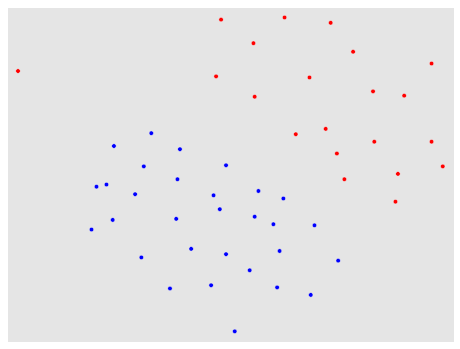

In [13]:
data = scipy.io.loadmat('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex6-005\\mlclass-ex6\ex6data1.mat')

X = data['X']
y = data['y']

# getting min and max of both first and second variable to limit the chart properly
x_min = X[:,0].min() - 0.1
x_max = X[:,0].max() + 0.1
y_min = X[:,1].min() - 0.1
y_max = X[:,1].max() + 0.1

print('This data can be easily separable by a line. We will play around with the C parameter and see how it affects a linear SVM!')

# plot the line, the points, and the nearest vectors to the plane
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.bwr)

plt.axis('tight')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xticks(())
plt.yticks(())
plt.show()

As C increases the margin shrinks and the data is fit more closely. The variance is increasing.
The decision function splits the space in the red and blue half planes, with support vectors identified with circles.


c:\users\pochetti\appdata\local\continuum\anaconda\envs\foodproject\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


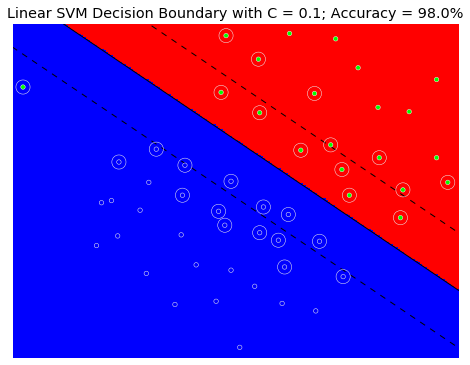

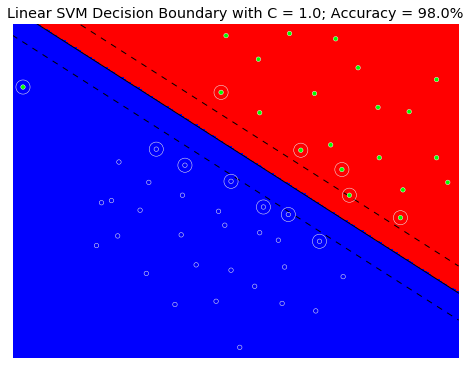

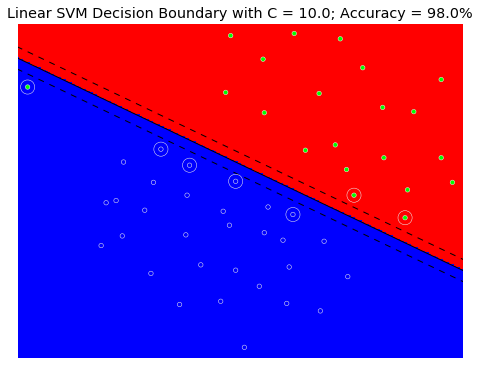

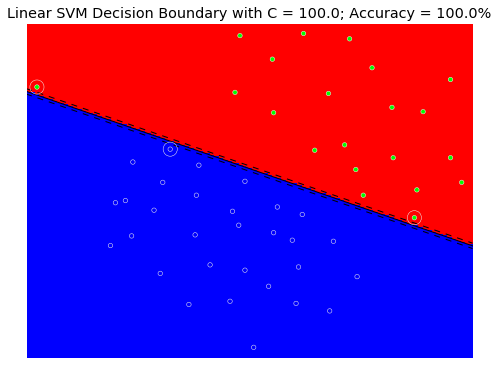

In [14]:
print('As C increases the margin shrinks and the data is fit more closely. The variance is increasing.')
print('The decision function splits the space in the red and blue half planes, with support vectors identified with circles.')

for C in [0.1, 1, 10, 100]:
    clf = svm.SVC(kernel='linear', C=C)
    clf.fit(X, y)
    accuracy = (clf.predict(X).reshape(-1,1) == y.reshape(-1,1)).sum()/y.shape[0]
        
    # w in this case is a <2,1> vector containing theta1 and theta2, the optimized coefficients related to x1 and x2
    w = clf.coef_[0]
    # line slope
    a = -w[0] / w[1]
    # generating an x grid
    xx = np.linspace(x_min, x_max)
    # calculating the decision boundary function on the x grid
    # clf.intercept_[0] is actually equal to theta0
    yy = a * xx - (clf.intercept_[0]) / w[1]
    
    # the margin is equal to the inverse of the squared norm on theta
    # this is due to the fact that for all the support vectors (falling on the margin) the below equation holds
    # margin * (norm(theta))^2 = 1
    margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
    
    # calculating the above and below parallels to the decision buondary to plot the margin
    yy_down = yy + a * margin
    yy_up = yy - a * margin
    
    # plot the line, the points, and the nearest vectors to the plane
    plt.figure(figsize=(8, 6))
    plt.clf()
    plt.plot(xx, yy, 'k-')
    plt.plot(xx, yy_down, 'k--')
    plt.plot(xx, yy_up, 'k--')
    
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=200, facecolors='none', zorder=10)
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.brg)
    
    plt.axis('tight')
    plt.title('Linear SVM Decision Boundary with C = %2.1f; Accuracy = %2.1f%%' % (C, accuracy*100))
    
    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])
    
    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z, cmap=plt.cm.bwr)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    plt.xticks(())
    plt.yticks(())
    plt.show()

### Exploring the Gaussian Kernel 

This dataset is definitely not separable by a straight line. We need to explore Gaussian Kernels for this challenge!


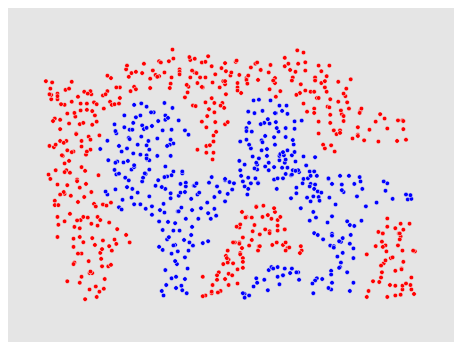

In [15]:
print('This dataset is definitely not separable by a straight line. We need to explore Gaussian Kernels for this challenge!')

data = scipy.io.loadmat('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex6-005\\mlclass-ex6\ex6data2.mat')

X = data['X']
y = data['y']

# getting min and max of both first and second variable to limit the chart properly
x_min = X[:,0].min() - 0.1
x_max = X[:,0].max() + 0.1
y_min = X[:,1].min() - 0.1
y_max = X[:,1].max() + 0.1

# plot the line, the points, and the nearest vectors to the plane
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.bwr)

plt.axis('tight')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xticks(())
plt.yticks(())
plt.show()

Look at how C impacts the variance of the Gaussian Kernel in the SVM classifier


c:\users\pochetti\appdata\local\continuum\anaconda\envs\foodproject\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


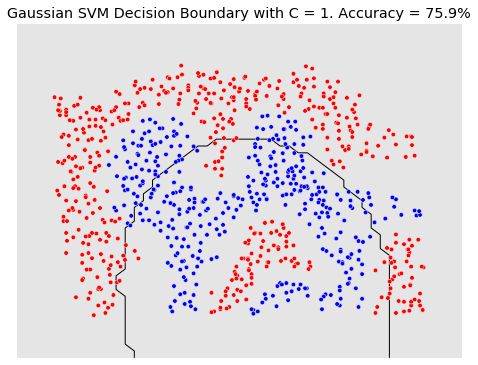

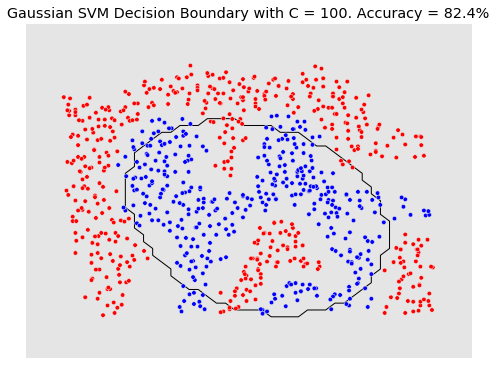

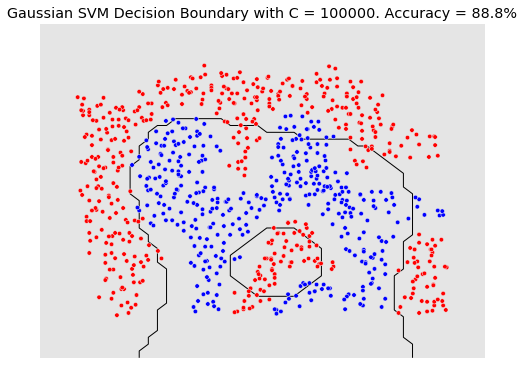

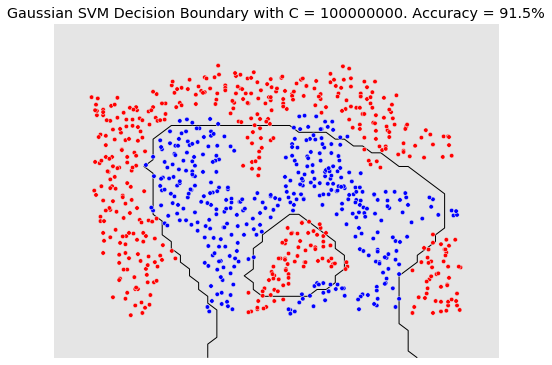

In [16]:
print('Look at how C impacts the variance of the Gaussian Kernel in the SVM classifier')

for C in [1e+0, 1e+2, 1e+5, 1e+8]:
    clf = svm.SVC(kernel='rbf', C=C)
    clf.fit(X, y)
    accuracy = (clf.predict(X).reshape(-1,1) == y.reshape(-1,1)).sum()/y.shape[0]

    # generating an evenly spaced grid to evaluate the classifier's predictions
    xx = np.linspace(x_min, x_max)
    yy = np.linspace(y_min, y_max)
    
    z = np.zeros((len(xx), len(yy)));
    for i in np.arange(len(xx)):
        for j in np.arange(len(yy)):
            z[i,j]= clf.predict(np.c_[np.atleast_1d(xx[i]), np.atleast_1d(yy[j])])

    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.bwr)

    plt.axis('tight')
    plt.title('Gaussian SVM Decision Boundary with C = %d. Accuracy = %2.1f%%' % (C, accuracy*100))

    cs = plt.contour(xx, yy, z.T, linewidth=4, levels=[0], colors='k')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xticks(())
    plt.yticks(())

    plt.show()

## SVM eMail Spam Classifier 

Many email services today provide spam filters that are able to classify emails into spam and non-spam email with high accuracy. In this part of the playground, we will use SVMs to build your own spam filter!

### Functions 

In [183]:
def getVocabList():
    d = {}
    with open('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex6-005\\mlclass-ex6\\vocab.txt') as f:
        for line in f:
           (key, val) = line.split()
           d[int(key)] = val
    return d

def processEmail(emailfile):
    with open(emailfile, 'r') as myfile:
        email = myfile.read()
    
    original = email
    email = email.replace('\n', ' ')
    email = re.sub('<.*?>', '', email) # strip HTML tags
    email = re.sub('[0-9]+', 'number', email) # replace any number with 'number'
    email = re.sub('(http|https)://[^\s]*', 'httpaddr', email) # replace any web address with 'httpaddr'
    email = re.sub('[^\s]+@[^\s]+', 'emailaddr', email) # replace any email address with 'emailaddr'
    email = re.sub('[$]+', 'dollar', email) # replace any dollar sign and amount coming after with 'dollar'
    email = re.sub('[^a-zA-Z0-9]', ' ', email) # remove any non alpha-numerical character
    
    email = email.lower().split(' ') # lower case and splitting email in lits if words
    
    # remove english stop words and any space and then stemming all words
    sno = nltk.stem.SnowballStemmer('english')
    email = list(set([sno.stem(word) for word in email if word not in stopwords.words('english') and word != '']))
    
    vocab = getVocabList()
    # return a list of indexes corresponding to each word in the email matching a word in the spam dictionary
    email = [index for index, word in vocab.items() for email_word in email if word == email_word]
    
    return email, original

def emailFeatures(indexes):
    vocab = getVocabList()
    x = np.zeros((len(vocab.keys()), 1))
    for index in indexes:
        x[index - 1, 0] = 1
    
    return x

### Training the Spam Classifier

In [179]:
train = scipy.io.loadmat('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex6-005\\mlclass-ex6\spamTrain.mat')
test = scipy.io.loadmat('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex6-005\\mlclass-ex6\spamTest.mat')

X_train = train['X']
y_train = train['y']
X_test = test['Xtest']
y_test = test['ytest']

clf = svm.SVC(kernel='linear', C=0.1)
clf.fit(X_train, y_train)

c:\users\pochetti\appdata\local\continuum\anaconda\envs\foodproject\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Train/Test Set Results 

In [182]:
train_accuracy = (clf.predict(X_train).reshape(-1,1) == y_train.reshape(-1,1)).sum()/y_train.shape[0]

test_accuracy = (clf.predict(X_test).reshape(-1,1) == y_test.reshape(-1,1)).sum()/y_test.shape[0]
print('Linear SVM Decision Boundary with C = 0.1. Train Accuracy = %2.1f%%; Test Accuracy = %2.1f%%' % (train_accuracy*100, test_accuracy*100))

Linear SVM Decision Boundary with C = 0.1. Train Accuracy = 99.8%; Test Accuracy = 98.9%


### Running the Spam Classifier on unseen eMails 

In [192]:
from nltk.corpus import stopwords
import re
import nltk

nonspam = 'C:\\Users\\pochetti\Machine_Learning\\mlclass-ex6-005\\mlclass-ex6\\emailSample1.txt'
spam = 'C:\\Users\\pochetti\Machine_Learning\\mlclass-ex6-005\\mlclass-ex6\\spamSample1.txt'

word_indices_n, original_n = processEmail(nonspam)
word_indices_s, original_s = processEmail(spam)

### Non Spam eMail example

In [191]:
print(original_n)

> Anyone knows how much it costs to host a web portal ?
>
Well, it depends on how many visitors you're expecting.
This can be anywhere from less than 10 bucks a month to a couple of $100. 
You should checkout http://www.rackspace.com/ or perhaps Amazon EC2 
if youre running something big..

To unsubscribe yourself from this mailing list, send an email to:
groupname-unsubscribe@egroups.com




In [195]:
print('Classified as (1 indicates spam, 0 indicates not spam):', clf.predict(emailFeatures(word_indices_n).T)[0])

Classified as (1 indicates spam, 0 indicates not spam): 0


### Spam eMail example 

In [196]:
print(original_s)

Do You Want To Make $1000 Or More Per Week?

 

If you are a motivated and qualified individual - I 
will personally demonstrate to you a system that will 
make you $1,000 per week or more! This is NOT mlm.

 

Call our 24 hour pre-recorded number to get the 
details.  

 

000-456-789

 

I need people who want to make serious money.  Make 
the call and get the facts. 

Invest 2 minutes in yourself now!

 

000-456-789

 

Looking forward to your call and I will introduce you 
to people like yourself who
are currently making $10,000 plus per week!

 

000-456-789



3484lJGv6-241lEaN9080lRmS6-271WxHo7524qiyT5-438rjUv5615hQcf0-662eiDB9057dMtVl72




In [197]:
print('Classified as (1 indicates spam, 0 indicates not spam):', clf.predict(emailFeatures(word_indices_s).T)[0])

Classified as (1 indicates spam, 0 indicates not spam): 1
